<a href="https://colab.research.google.com/github/computational-neurology/workshop2024/blob/main/02_single_node_dynamics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Questions on the previous lecture / homeworks + divide into groups
*15 mins*

<div class="alert alert-block alert-success">
<b>Exercise 0 </b><p>

*10 mins*

**Brainstorm**

Before we start with today's lecture, imagine you are tasked with creating a model of the brain's activity. How would you do it? Please, brainstorm within your group.

You can consider the following aspects, or suggest your own, completely different idea (no one has still been able to model the brain comprehensively, so there is no right or wrong!):

**Components and Structure**: What basic components would you include in your model? How would you represent the structure of the brain?

**Function and Dynamics**: How would you represent the activity and dynamics (e.g., change of activity over time) of these components? What kind of data might help you understand these dynamics?

**Interaction and Communication**: How would you model the interactions between different brain regions? Are interactions at all important?

**Simplifications and Assumptions**: Given the complexity of the brain, what simplifications or assumptions would you make to make the modeling process manageable? How might these affect your model's accuracy and applicability? <p>

    
<p>
 -End of exercise-
    </div>

# Building a model of the brain's activity


## Introduction
~ 10 mins

TODO: Insert Beautiful figure illustrating WBM

A possible way to simulate the activity of the brain over time is to use **whole-brain models**.

Whole-brain models encompass a collection of equations that depict the dynamics and interplay among neural populations across various brain regions. In simpler terms, you divide the brain in different regions (remember the parcellations of different colors from the previous lecture) and simulate the activity of each region over time using a differential equation (for those that don't have a maths background, don't be scared, we won't dive into the details). These equations can be either formulated based on an understanding of the biophysical mechanisms that underlie diverse brain activities (biophysical models, e.g., based on specific assumptions like neuronal membrane conductance), or they can be chosen based on the dynamics they generate (phenomenological models, they describe what we see pretty well, even though they don't arise from biological variables). The local dynamics between different regions are then combined with estimates of anatomical connectivity networks obtained from in vivo measurements (via the structural connectivity matrix we discussed in the previous lecture).

Most whole-brain models consist of three fundamental components:

- *Local dynamics:* The activity of each brain region is typically determined by the selected local dynamics along with interaction terms involving other regions (e.g non-linear oscillators, neural field theory, neural mass models, and dynamic mean-field models).

- *Brain parcellation:* A brain parcellation determines the number of regions and the spatial resolution at which the brain dynamics occur. This parcellation may include cortical, sub-cortical, and cerebellar regions.

- *Anatomical connectivity matrix:* This matrix defines the network of connections between brain regions. Many studies rely on the human connectome, which is derived by estimating the number of white-matter fibers connecting different brain areas using DTI data combined with probabilistic tractography.


In this tutorial we will cover some of the key components involved in computational modelling of mesoscopic single region dynamics. In the next lecture we will try to recreate a whole brain!

But first, what do we mean as dynamics?

## Small dictionary of dynamical systems:

<div class="alert alert-block alert-success">
<b>Exercise 1 </b><p>

*10 mins*

Before we move to modeling the brain, we will start with a brief general introduction on dynamical systems (not mathematical, but general). Nonetheless, there are a few keywords that will recur throughout this and future lecture you should familiarize with. Please go to ___ and try to answer the questions. These questions will allow you to start building a foundation of the main terminology used in the field.

    
<p>
 -End of exercise-
    </div>



## What is a dynamical system anyways?

*30 minutes*

In this part, we will start learning about behavior of dynamical systems -- systems that evolve in time -- where the rules by which they evolve in time are described precisely by a differential equation.

Differential equations are equations that express the **rate of change** of the state variable $x$. One typically describes this rate of change using the derivative of $x$ with respect to time ($dx/dt$) on the left hand side of the differential equation:

\begin{equation}
\frac{dx}{dt} = f(x)
\end{equation}

A common notational short-hand is to write $\dot{x}$ for $\frac{dx}{dt}$. The dot means "the derivative with respect to time".

For simplicity, the focus will be on **linear dynamics**, where $f(x)$ is a linear function of $x$. Now, we will:

* Explore and understand the behavior of such systems where $x$ is a single variable
* Consider cases where $\mathbf{x}$ is a state vector representing two variables.

In [ ]:
# @title Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp  # numerical integration solver

In [ ]:
# @title Figure settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets  # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [ ]:
# @title Plotting Functions
def plot_trajectory(system, params, initial_condition, dt=0.1, T=6,
                    figtitle=None):

  """
  Shows the solution of a linear system with two variables in 3 plots.
  The first plot shows x1 over time. The second plot shows x2 over time.
  The third plot shows x1 and x2 in a phase portrait.

  Args:
    system (function): a function f(x) that computes a derivative from
                        inputs (t, [x1, x2], *params)
    params (list or tuple): list of parameters for function "system"
    initial_condition (list or array): initial condition x0
    dt (float): time step of simulation
    T (float): end time of simulation
    figtitlte (string): title for the figure

  Returns:
    nothing, but it shows a figure
  """

  # time points for which we want to evaluate solutions
  t = np.arange(0, T, dt)

  # Integrate
  # use built-in ode solver
  solution = solve_ivp(system,
                    t_span=(0, T),
                    y0=initial_condition, t_eval=t,
                    args=(params),
                    dense_output=True)
  x = solution.y

  # make a color map to visualize time
  timecolors = np.array([(1 , 0 , 0, i)  for i in t / t[-1]])

  # make a large figure
  fig, (ah1, ah2, ah3) = plt.subplots(1, 3)
  fig.set_size_inches(10, 3)

  # plot x1 as a function of time
  ah1.scatter(t, x[0,], color=timecolors)
  ah1.set_xlabel('time')
  ah1.set_ylabel('x1', labelpad=-5)

  # plot x2 as a function of time
  ah2.scatter(t, x[1], color=timecolors)
  ah2.set_xlabel('time')
  ah2.set_ylabel('x2', labelpad=-5)

  # plot x1 and x2 in a phase portrait
  ah3.scatter(x[0,], x[1,], color=timecolors)
  ah3.set_xlabel('x1')
  ah3.set_ylabel('x2', labelpad=-5)
  #include initial condition is a blue cross
  ah3.plot(x[0,0], x[1,0], 'bx')

  # adjust spacing between subplots
  plt.subplots_adjust(wspace=0.5)

  # add figure title
  if figtitle is not None:
    fig.suptitle(figtitle, size=16)
  plt.show()


def plot_streamplot(A, ax, figtitle=None, show=True):
  """
  Show a stream plot for a linear ordinary differential equation with
  state vector x=[x1,x2] in axis ax.

  Args:
    A (numpy array): 2x2 matrix specifying the dynamical system
    ax (matplotlib.axes): axis to plot
    figtitle (string): title for the figure
    show (boolean): enable plt.show()

  Returns:
    nothing, but shows a figure
  """

  # sample 20 x 20 grid uniformly to get x1 and x2
  grid = np.arange(-20, 21, 1)
  x1, x2 = np.meshgrid(grid, grid)

  # calculate x1dot and x2dot at each grid point
  x1dot = A[0,0] * x1 + A[0,1] * x2
  x2dot = A[1,0] * x1 + A[1,1] * x2

  # make a colormap
  magnitude = np.sqrt(x1dot ** 2 + x2dot ** 2)
  color = 2 * np.log1p(magnitude) #Avoid taking log of zero

  # plot
  plt.sca(ax)
  plt.streamplot(x1, x2, x1dot, x2dot, color=color,
                 linewidth=1, cmap=plt.cm.cividis,
                 density=2, arrowstyle='->', arrowsize=1.5)
  plt.xlabel(r'$x1$')
  plt.ylabel(r'$x2$')

  # figure title
  if figtitle is not None:
    plt.title(figtitle, size=16)

  # include eigenvectors
  if True:
    # get eigenvalues and eigenvectors of A
    lam, v = np.linalg.eig(A)

    # get eigenvectors of A
    eigenvector1 = v[:,0].real
    eigenvector2 = v[:,1].real

    # plot eigenvectors
    plt.arrow(0, 0, 20*eigenvector1[0], 20*eigenvector1[1],
              width=0.5, color='r', head_width=2,
              length_includes_head=True)
    plt.arrow(0, 0, 20*eigenvector2[0], 20*eigenvector2[1],
              width=0.5, color='b', head_width=2,
              length_includes_head=True)
  if show:
    plt.show()


def plot_specific_example_stream_plots(A_options):
  """
  Show a stream plot for each A in A_options

  Args:
    A (list): a list of numpy arrays (each element is A)

  Returns:
    nothing, but shows a figure
  """
  # get stream plots for the four different systems
  plt.figure(figsize=(10, 10))

  for i, A in enumerate(A_options):

    ax = plt.subplot(2, 2, 1+i)
    # get eigenvalues and eigenvectors
    lam, v = np.linalg.eig(A)

    # plot eigenvalues as title
    # (two spaces looks better than one)
    eigstr = ",  ".join([f"{x:.2f}" for x in lam])
    figtitle =f"A with eigenvalues\n"+ '[' + eigstr + ']'
    plot_streamplot(A, ax, figtitle=figtitle, show=False)

    # Remove y_labels on righthand plots
    if i % 2:
      ax.set_ylabel(None)
    if i < 2:
      ax.set_xlabel(None)

    plt.subplots_adjust(wspace=0.3, hspace=0.3)
  plt.show()

Let's start by reminding ourselves of a one-dimensional differential equation in $x$ of the form

$$\dot{x} = a x$$

where $a$ is a scalar.

Solutions for how $x$ evolves in time when its dynamics are governed by such a differential equation take the form

\begin{equation}
x(t) = x_0 e^{(a t)}
\end{equation}

where $x_0$ is the **initial condition** of the equation -- that is, the value of $x$ at time $0$.
</details>

To gain further intuition, let's explore the behavior of such systems with a simple simulation. We can simulate an ordinary differential equation by approximating or modeling time as a discrete list of time steps $t_0, t_1, t_2, \dots$, such that $t_{i+1}=t_i+dt$. We can get the small change $dx$ over a small duration $dt$ of time from the definition of the differential:

\begin{eqnarray}
\dot x &=& \frac{dx}{dt} \\
dx &=& \dot x\, dt
\end{eqnarray}

So, at each time step $t_i$, we compute a value of $x$, $x(t_i)$, as the sum of the value of $x$ at the previous time step, $x(t_{i-1})$ and a small change $dx=\dot x\,dt$:

\begin{equation}
x(t_i)=x(t_{i-1})+\dot x(t_{i-1}) dt
\end{equation}

This very simple integration scheme, known as **forward Euler integration**, works well if $dt$ is small and the ordinary differential equation is simple. It can run into issues when the ordinary differential equation is very noisy or when the dynamics include sudden big changes of $x$. Such big jumps can occur, for example, in models of excitable neurons. In such cases, one needs to choose an integration scheme carefully. However, for our simple system, the simple integration scheme should work just fine!

<div class="alert alert-block alert-success">
<b>Exercise 2 </b><p>

Complete the following code to perform the forward Euler Integration scheme.

Hint: Look at the equations we just presented above

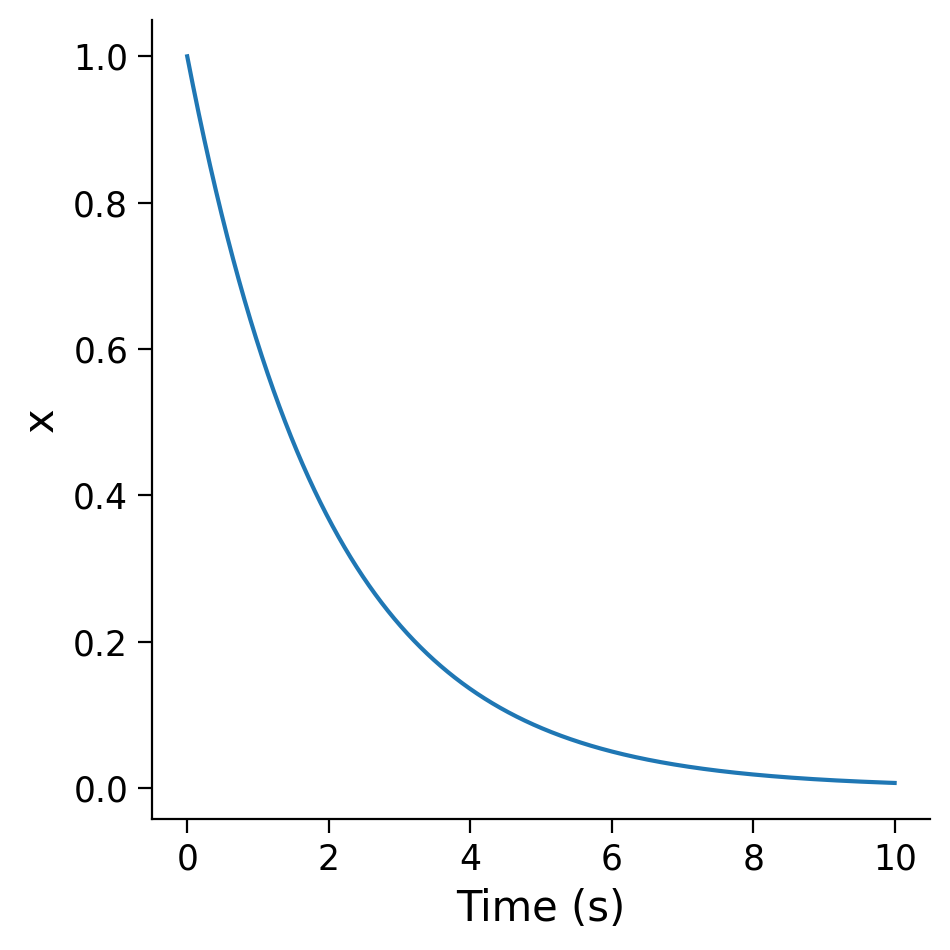

In [ ]:
def integrate_exponential(a, x0, dt, T):
  """Compute solution of the differential equation xdot=a*x with
  initial condition x0 for a duration T. Use time step dt for numerical
  solution.

  Args:
    a (scalar): parameter of xdot (xdot=a*x)
    x0 (scalar): initial condition (x at time 0)
    dt (scalar): timestep of the simulation
    T (scalar): total duration of the simulation

  Returns:
    ndarray, ndarray: `x` for all simulation steps and the time `t` at each step
  """

  # Initialize variables
  t = np.arange(0, T, dt)
  x = np.zeros_like(t, dtype=complex)
  x[0] = x0 # This is x at time t_0

  # Step through system and integrate in time
  for k in range(1, len(t)):

    ## Fill out the following

    xdot = ...

    # Update x based on x[k-1] and xdot
    x[k] =...

  return x, t


# Choose parameters
a = -0.5    # parameter in f(x)
T = 10      # total Time duration
dt = 0.001  # timestep of our simulation
x0 = 1.     # initial condition of x at time 0

# Use Euler's method
x, t = integrate_exponential(a, x0, dt, T)

# Visualize
plt.figure(figsize = (5,5))
plt.plot(t, x.real)
plt.xlabel('Time (s)')
plt.ylabel('x')
plt.show()

    
<p>
 -End of exercise-
    </div>


<div class="alert alert-block alert-success">
<b>Exercise 2 </b><p>

1.  What happens when you change $a$? Try values where $a<0$ and $a>0$. What do you see?

2.  The $dt$ is the step size of the forward Euler integration. Try $a = -1.5$ and increase $dt$. What happens to the numerical solution when you increase $dt$?


In [ ]:
# @title Make sure you execute this cell to enable the widget!

T = 10  # total Time duration
x0 = 1.  # initial condition of x at time 0

@widgets.interact(
    a=widgets.FloatSlider(value=-0.5, min=-2.5, max=1.5, step=0.25,
                          description="α", readout_format='.2f'),
    dt=widgets.FloatSlider(value=0.001, min=0.001, max=1.0, step=0.001,
                           description="dt", readout_format='.3f')
    )

def plot_euler_integration(a, dt):
  # Have to do this clunky word around to show small values in slider accurately
  # (from https://github.com/jupyter-widgets/ipywidgets/issues/259)

  x, t = integrate_exponential(a, x0, dt, T)
  plt.figure(figsize=(5,5))
  plt.plot(t, x.real)  # integrate_exponential returns complex
  plt.xlabel('Time (s)')
  plt.ylabel('x')
  plt.show()

interactive(children=(FloatSlider(value=-0.5, description='α', max=1.5, min=-2.5, step=0.25), FloatSlider(valu…

<p>
 -End of exercise-
    </div>


<div class="alert alert-block alert-success">
<b> Bonus Exercise </b><p>

In the following exercise, you can change the real part and imaginary part of $a$ (so a = real + imaginary i)

1. What values of $a$ produce dynamics that both ***oscillate*** and ***grow***?
2. What value of $a$ is needed to produce a stable oscillation of 0.5 Hertz (cycles/time units)?


In [ ]:
# @title Make sure you execute this cell to enable the widget!

# parameters
T = 5  # total Time duration
dt = 0.0001  # timestep of our simulation
x0 = 1.  # initial condition of x at time 0

@widgets.interact
def plot_euler_integration(real=(-2, 2, .2), imaginary=(-4, 7, .1)):

  a = complex(real, imaginary)
  x, t = integrate_exponential(a, x0, dt, T)
  plt.figure(figsize=(5,5))
  plt.plot(t, x.real)  # integrate exponential returns complex
  plt.grid(True)
  plt.xlabel('Time (s)')
  plt.ylabel('x')
  plt.show()

interactive(children=(FloatSlider(value=0.0, description='real', max=2.0, min=-2.0, step=0.2), FloatSlider(val…

In [ ]:
# @title Solution, click to check if your idea is correct!
# 1) To make the system both oscillate and grow, real has to be positive,
# and imaginary has to be not zero.

# 2) Stable oscillation of 0.5 Hz (half a cycle per unit time, or one cycle per two
# unit time) is achieved with real = 0 and imaginary = +/- pi
# (approximately 3.1 or -3.1).

## Pause: 15 mins

# Node-level dynamics
Now that we have a general idea of what a dynamical system is and how numerical solutions work, we will start to build our own model of the brain. First, we will code our own simulation, then we will introduce a Python package called [Neurolib](https://github.com/neurolib-dev/neurolib) allowing for easy simulations of whole-brain functional activity.

Neurolib is very fast and easy to use, but there is also other software allowing you to do the same kinds of simulations, like [The Virtual Brain](https://thevirtualbrain.org/tvb/zwei) (TVB). With TVB you also get a graphical user interface if you are yet not too keen on programming, but want to explore whole-brain models while improving your coding skills. The only drawback from TVB is that it is currently pretty slow.

The same concepts you will learn today, though, also apply to TVB or any other whole-brain modeling packages.

TODO: insert images on biophysical versus phenomenological models

## Biophysical versus Phenomenological models of brain activity

~ 5 mins

Broadly speaking, there are two categories of neural mass models: biophysical and phenomenological.

**Biophysical Models**

Biophysical modeling is an approach that aims to capture the biological details of neural populations. This means that biophysical models are grounded in the biophysical properties of neurons, such as ion channel dynamics, neurotransmitter kinetics, and synaptic plasticity. Biophysical models often incorporate detailed representations of biological entities, such as conductances, which correspond to the flow of ions across neuronal membranes.

**Phenomenological Models**

In contrast to biophysical modeling, phenomenological modeling takes a more abstract and high-level approach. Instead of focusing on the detailed biophysical mechanisms, phenomenological models aim to capture the qualitative behavior and emergent properties of neural systems. This means that we have recordings of empirical data and we have some mathematical equations that try to capture these recordings as best as possible. These models often use mathematical frameworks and computational techniques to describe and simulate the observed phenomena without necessarily incorporating the underlying biological details.

*E.g., You can approximate the hourly temperature over the course of a month with a sinusoidal wave, where the temperature will be higher during the day and lower during the night. You have no idea why, but this still allows you to understand some things (like maybe you have higher excursion between day and night in a place i.e., the desert, compared to another). Here, our model provides a mathematical description of the observed phenomenon (periodic temperature changes) without explaining the reasons behind it, such as the Earth's rotation, atmospheric dynamics, or thermodynamics.*

<div class="alert alert-block alert-success">
<b> Exercise 4 </b><p>

*~ 5 mins*

Can you think of some pros and cons for each group of models?


## Pros and cons of each type of model


**Pros of biophysical models**:
The strength of biophysical modeling lies in its ability to provide a mechanistic understanding of neural processes by directly linking them to the underlying biological components. These models can help researchers explore how specific biophysical parameters influence neural behavior and test hypotheses about the role of different cellular and molecular mechanisms in shaping neural activity.

**Cons of biophysical models**:
The main downside of these models is that the more biological realism comes with a higher number of coupled differential equations to be solved, up to ~thousands for each neuron (e.g., each type of ion channel should have its own equation, then equations for ion channels on dendrites are different depending on the morphology, and so on). Even with massive computing power and parallelism, this currently poses severe technical limitations on the number of neurons we can simulate at the highest level of biological realism (currently ~ some squared cm). Nonetheless we can use simplified models where we describe with just a couple of differential equations the activity of ~millions of neurons, allowing us to simulate whole-brain activity.

**Pros of phenomenological models**:
Phenomenological models are particularly useful when the precise biological mechanisms are not well understood or when the goal is to study the collective behavior of large-scale neural networks. These models can provide insights into the computational principles and information processing capabilities of neural systems, without being constrained by the complexities of biological details. This allows to run several modeling simulations at a large-scale in many individuals, which is currently much more computationally expensive with biophysically detailed models

**Cons of phenomenological models**:
Being phenomenological, these models do not allow us to delve into the molecular, biophysical and cellular mechanisms. This is a great limitation if you want to know exactly what to change in order to achieve a particular state and how to do it.


While biophysical and phenomenological modeling approaches may seem distinct, they are often complementary in computational neuroscience and many models share some degree of both approaches. Biophysical models can inform and constrain phenomenological models by providing a biological foundation and validating the assumptions made in the abstract models. Conversely, phenomenological models can guide the development of biophysical models by identifying relevant phenomena and suggesting potential mechanisms to be explored.

## Normal form of a supercritical Hopf bifurcation

In [ ]:
import sys
!{sys.executable} -m pip install neurolib
# @title Install dependencies


We will start by simulating single node activity, employing the *Normal form of a supercritical Hopf bifurcation* (a.k.a. Stuart-Landau model).

The dynamics of a single node $i$ is given by the following differential equation, with complex variable $z$ as the state variable:


$$\dot{z}_{i} = (a_{i} + i\omega_{i})z_{i} - z_{i} |z_{i}^2| $$


The real part of $z$ is what we measure empirically, its imaginary part serves only for the equations, we can then write:

$$\dot{x}_{i} = (a_{i} - x_{i}^{2} - y_{i}^{2})x_{i} - \omega_{i}y_{i}$$

$$\dot{y}_{i} = (a_{i} - x_{i}^{2} - y_{i}^{2})y_{i} + {\omega}{i}x_{i} $$

$a$ is known as a bifurcation parameter and $\omega$ is the natural frequency of oscillation.

- If $a<0$ the system is characterised by a single stable point and
- if $a>0$ a limit cycle emerges and the system oscillates harmonically, with frequency $\omega$.
- The bifurcation point, is thus at $a=0$.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
a = -0.1  # Bifurcation parameter
omega = 1  # Angular frequency

# Initial conditions
x0 = 0.1
y0 = 0.1

# Time span and step size
t_start = 0.0
t_end = 100.0
dt = 0.01
t = np.arange(t_start, t_end, dt)

# Supercritical Hopf bifurcation normal form
def hopf_normal_form(x, y, a, omega):

    dx_dt = (a - x**2 - y**2) * x - omega * y
    dy_dt = (a - x**2 - y**2) * y + omega * x

    return dx_dt, dy_dt

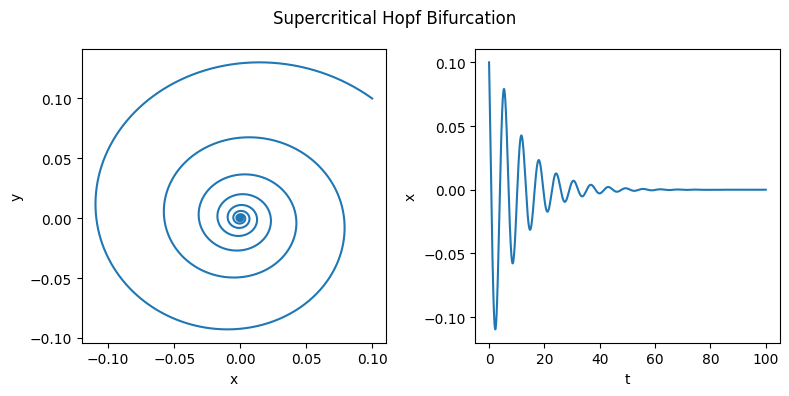

In [ ]:
x = np.zeros_like(t)
y = np.zeros_like(t)
x[0] = x0
y[0] = y0

for i in range(1, len(t)):
    dx, dy = hopf_normal_form(x[i-1], y[i-1], a, omega)
    x[i] = x[i-1] + dx * dt
    y[i] = y[i-1] + dy * dt

# Plotting
fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (8,4))
axs[0].plot(x, y)
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[1].plot(t, x)
axs[1].set_xlabel('t')
axs[1].set_ylabel('x')

fig.suptitle('Supercritical Hopf Bifurcation')
fig.tight_layout()
fig.show()

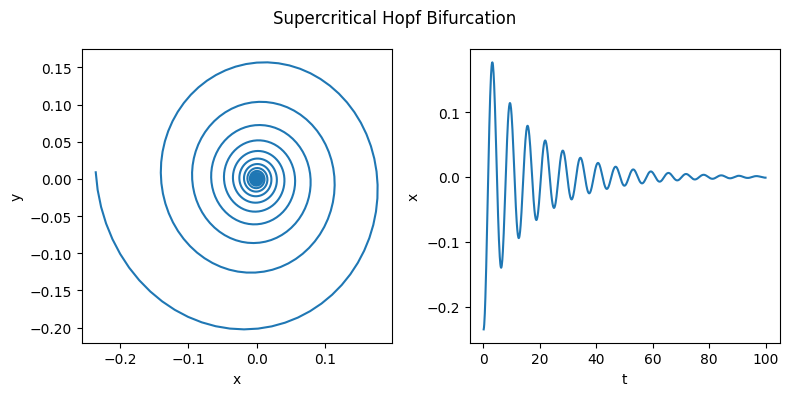

In [ ]:
# Let's import the Hopf model
from neurolib.models.hopf import HopfModel

model = HopfModel()
model.params['duration'] = 100
model.params['sigma_ou'] = 0.00
model.params['a'] = -0.1
model.params["w"] = 1

model.run()

fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (8,4))
axs[0].plot(model.x.T, model.y.T)
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')
axs[1].plot(model.t, model.x.T)
axs[1].set_xlabel('t')
axs[1].set_ylabel('x')
fig.suptitle('Supercritical Hopf Bifurcation')
fig.tight_layout()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider

# Initialize model
model = HopfModel()
model.params['duration'] = 1.0 * 1000
model.params['sigma_ou'] = 0.0 # Noise
model.run()

# Function to update plot
def update_plot(bifurcation_param):
    model.params['a'] = bifurcation_param
    model.run()
    plt.figure(figsize=(8, 6))
    plt.plot(model.t, model.x.T, c='k', lw=2)
    plt.xlabel("t [ms]")
    plt.ylabel("Activity")
    plt.title(f"Bifurcation parameter: {bifurcation_param}")
    plt.grid(True)
    plt.show()

# Create interactive widget
interact(update_plot, bifurcation_param=FloatSlider(min=-0.5, max=0.5, step=0.01, value=0.2));


interactive(children=(FloatSlider(value=0.2, description='bifurcation_param', max=0.5, min=-0.5, step=0.01), O…

Text(0, 0.5, 'Activity')

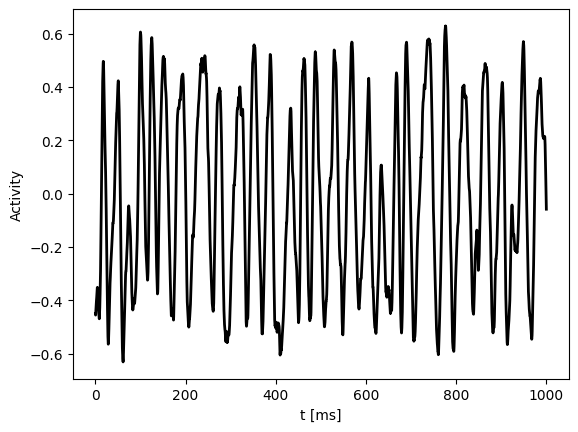

In [ ]:
plt.plot(model.t, model.x.T, c='k', lw = 2)
# alternatively plot the results in the xarray:
# plt.plot(hopfModel.xr[0, 0].time, hopfModel.xr[0, 0].values)
plt.xlabel("t [ms]")
plt.ylabel("Activity")

In [ ]:
model = HopfModel()
model.params['duration'] = 2.0*1000

In [ ]:
max_x = []
min_x = []
# these are the different input values that we want to scan
a_s = np.linspace(-2, 2, 50)
for a in a_s:
    model.params['a'] = a
    model.run()
    # we add the maximum and the minimum of the last second of the
    # simulation to a list
    max_x.append(np.max(model.x[0, -int(1000/model.params['dt']):]))
    min_x.append(np.min(model.x[0, -int(1000/model.params['dt']):]))

Text(0, 0.5, 'Min / max x')

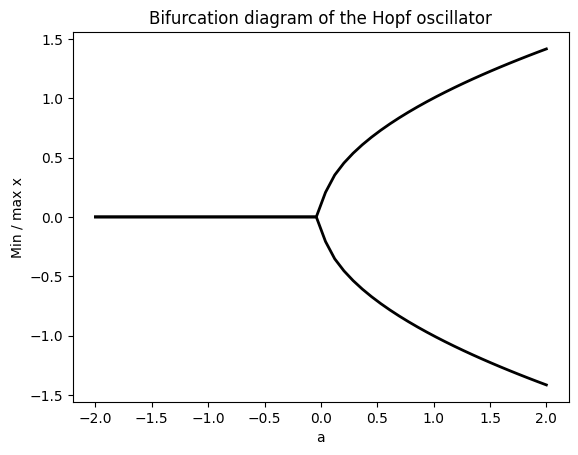

In [ ]:
plt.plot(a_s, max_x, c='k', lw = 2)
plt.plot(a_s, min_x, c='k', lw = 2)
plt.title("Bifurcation diagram of the Hopf oscillator")
plt.xlabel("a")
plt.ylabel("Min / max x")

## Conclusions

With this notebook you should have developed an initial understanding of:

- **Dynamical systems**
- **Neural mass modeling**
- **Implementing single node dynamics**

Having gained an understanding of how modeling a single/few regions works and different parameter configurations impact their dynamics, in the next lecture we will expand our analysis to the whole-brain level at a macro-scale, dividing the brain into sub-regions and connecting them using structural connectome data derived from Diffusion Weighted Imaging data.


# Acknowledgments
Parts of this tutorial were taken from [Neuromatch Academy](https://compneuro.neuromatch.io/tutorials/intro.html). Their course on Computational Neuroscience delves into many more details on dynamical systems and biophysically detailed neural mass models. If you are interested in these topics, it is free to follow at your own pace.

[TVB](https://wiki.ebrains.eu/bin/view/Collabs/documentation/tutorials/The%20Virtual%20Brain/) also offers some more tutorials



## Further reading for those interested

*Further reading introductions to WBM*

- C. Cakan, N. Jajcay, K. Obermayer, neurolib: A Simulation Framework for Whole-Brain Neural Mass Modeling. Cogn Comput (2021). https://doi.org/10.1007/s12559-021-09931-9.

- A. Pathak, D. Roy, A. Banerjee, Whole-Brain Network Models: From Physics to Bedside. Front Comput Neurosci 16, 866517 (2022).

- Griffiths, J.D., Bastiaens, S.P., Kaboodvand, N. (2022). Whole-Brain Modelling: Past, Present, and Future. In: Giugliano, M., Negrello, M., Linaro, D. (eds) Computational Modelling of the Brain. Advances in Experimental Medicine and Biology(), vol 1359. Springer, Cham. https://doi.org/10.1007/978-3-030-89439-9_13 (*general concepts + history, it should be available through RUB online*)

- Models of the Mind: How Physics, Engineering and Mathematics Have Shaped Our Understanding of the Brain by Grace Lindsay (this is a interesting entry-level book on the history of computational neuroscience and how mathematical models have been used to explore properties of the brain)

___
*Dynamical systems in WBM*

- M. Breakspear, Dynamic models of large-scale brain activity. Nat Neurosci 20, 340–352 (2017) (*general principles*)

- P. Sanz-Leon, S. A. Knock, A. Spiegler, V. K. Jirsa, Mathematical framework for large-scale brain network modeling in The Virtual Brain. NeuroImage 111, 385–430 (2015) (*all the math we did not cover today is presented here*)


___
*Criticality*

- J. O’Byrne, K. Jerbi, How critical is brain criticality? Trends in Neurosciences 45, 820–837 (2022).

- L. Cocchi, L. L. Gollo, A. Zalesky, M. Breakspear, Criticality in the brain: A synthesis of neurobiology, models and cognition. Progress in Neurobiology 158, 132–152 (2017).

___
*Moving towards clinical applications*

- G. Deco, V. K. Jirsa, A. R. McIntosh, Resting brains never rest: computational insights into potential cognitive architectures. Trends Neurosci 36, 268–274 (2013).

- G. Deco, M. L. Kringelbach, Great Expectations: Using Whole-Brain Computational Connectomics for Understanding Neuropsychiatric Disorders. Neuron 84, 892–905 (2014).

- X. Kobeleva, et al., Advancing brain network models to reconcile functional neuroimaging and clinical research. NeuroImage: Clinical 36, 103262 (2022).


